# HW4

Hi!

In this notebook, I create multiple embedding representations for the phrasal verb data found [here](https://github.com/johnstarr-ling/light-verb-construction-embeddings/tree/main/data), and then train various SVM classifiers using these representations.

The kinds of embeddings that I currently use are:
1. pre-trained Word2Vec word embeddings (300d, trained on Google News Corpus)
2. pre-trained Word2Vec word embeddings (300d, trained on Google News Corpus), with phrasal verb as one compositional embedding (mean pooling)
3. pre-trained GLoVe word embeddings (300d, trained on Wikipedia 2014 + Gigaword 5 corpora)
4. pre-trained GLoVe word embeddings (300d, trained on Wikipedia 2014 + Gigaword 5 corpora), with phrasal verb as one compositional embedding (mean pooling)
5. [InferSent](https://github.com/facebookresearch/InferSent) sentence embeddings

Embedding representations that I expect to use in the future include:
1. BERT

__NOTE ON RUNNING THIS NOTEBOOK:__ This notebook requires the following files to be in the same directory for a successful run:
1. [models.py](https://github.com/facebookresearch/InferSent/blob/main/models.py) file from InferSent
2. [a pretrained GLoVe embedding .txt file](https://nlp.stanford.edu/projects/glove/)

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import torch 

In [2]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

We'll load in our phrasal verb data:

In [3]:
data = pd.read_csv('data/pvc_data.csv')

In [4]:
data.head()

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents
0,"['take', 'on']",B/BN/BNN.xml,291,True,1.0000,"['12', '13']","['At', 'about', 'the', 'same', 'time', 'the', ..."
1,"['give', 'in']",B/B1/B1E.xml,670,False,0.7051,"['15', '16']","['Production', 'is', 'centred', 'in', 'the', '..."
2,"['take', 'after']",K/K3/K3E.xml,56,False,0.6733,"['21', '22']","['By', 'Echo', 'reporter', 'CORONATION', 'Stre..."
3,"['get', 'out']",C/CK/CK9.xml,1654,True,1.0000,"['19', '20']","['Mrs', 'Aggie', ',', 'I', 'do', 'want', 'to',..."
4,"['get', 'through']",G/G2/G2E.xml,2734,True,1.0000,"['9', '10']","['He', 'was', 'charged', 'for', 'a', 'call', '..."


In [5]:
# Making sure all our data are in the right form
data['pvc_lemmas'] = data['pvc_lemmas'].apply(eval)
data['row'] = data['row'].apply(int)
data['annotator_agreement_percentage'] = data['annotator_agreement_percentage'].apply(float)
data['verb_idx'] = data['verb_idx'].apply(eval)
data['sents'] = data['sents'].apply(eval)
data['pvc_strings'] = data['pvc_lemmas'].apply(lambda x: ' '.join(x))
data['sent_strings'] = data['sents'].apply(lambda x: ' '.join(x))


## InferSent

Most of the following code is taken from [here](https://github.com/facebookresearch/InferSent/blob/main/demo.ipynb).

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Load model
from model import InferSent
model_version = 1
MODEL_PATH = "infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [8]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'glove.6B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [9]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [10]:
# Some test sentences!
test_lvcs = ['I gave John a bath .', 'I gave John a book .', 'I gave John a chance .']

In [11]:
test_embeds = model.encode(test_lvcs, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(test_lvcs)))

Nb words kept : 12/24 (50.0%)
Speed : 49.3 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 3


In [12]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [13]:
cosine(model.encode(['I gave John a bath.'])[0], model.encode(['I gave John a book.'])[0])

0.86921847

In [14]:
# Phrasal verb embedding
pv_embeddings = model.encode(data['pvc_strings'], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(pv_embeddings)))

Nb words kept : 2616/5142 (50.9%)


C:\Users\johns\Documents\grad_school\research\light-verb-construction-embeddings\model.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 855.8 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 1263


In [15]:
# Whole sentence embedding
sent_embeddings = model.encode(data['sent_strings'], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(sent_embeddings)))

Nb words kept : 30795/36617 (84.1%)
Speed : 63.0 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 1263


In [16]:
# Adding these to the DataFrame
pv_infer_list = list(pv_embeddings)
sent_infer_list = list(sent_embeddings)

In [17]:
data['pv_infer_embeds'] = pv_infer_list
data['sent_infer_embeds'] = sent_infer_list

In [18]:
data.head()

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents,pvc_strings,sent_strings,pv_infer_embeds,sent_infer_embeds
0,"[take, on]",B/BN/BNN.xml,291,True,1.0000,"[12, 13]","[At, about, the, same, time, the, aliens, depa...",take on,At about the same time the aliens department o...,"[0.04849784, 0.082029976, 0.010337902, 0.00278...","[0.12564819, 0.06340436, 0.055802934, 0.096010..."
1,"[give, in]",B/B1/B1E.xml,670,False,0.7051,"[15, 16]","[Production, is, centred, in, the, Pacific, no...",give in,Production is centred in the Pacific northwest...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07641017, 0.13320042, 0.008155916, 0.096234..."
2,"[take, after]",K/K3/K3E.xml,56,False,0.6733,"[21, 22]","[By, Echo, reporter, CORONATION, Street, actre...",take after,By Echo reporter CORONATION Street actress Lyn...,"[0.04559154, 0.013943457, 0.013154965, -0.0398...","[0.116348945, 0.07574034, 0.013408521, 0.07490..."
3,"[get, out]",C/CK/CK9.xml,1654,True,1.0000,"[19, 20]","[Mrs, Aggie, ,, I, do, want, to, go, to, a, sc...",get out,"Mrs Aggie , I do want to go to a school where ...","[0.04216131, -0.040760946, -0.071714684, -0.00...","[0.08019499, 0.06795283, 0.053973824, 0.092289..."
4,"[get, through]",G/G2/G2E.xml,2734,True,1.0000,"[9, 10]","[He, was, charged, for, a, call, that, never, ...",get through,He was charged for a call that never got throu...,"[0.07250941, -0.0235534, -0.04305069, 0.039528...","[0.07009956, 0.052870482, 0.08822129, 0.059288..."


## W2V

In [19]:
import gensim.downloader

In [20]:
w2v = gensim.downloader.load('word2vec-google-news-300')


In [21]:
# Creating an <UNK> that is the mean of all vectors in the space
w2v['<UNK>'] = np.mean([w2v[x] for x in w2v.key_to_index.keys()], axis=0)


In [22]:
# Gets the vectors to the list
def get_w2v_list(word_list, vectors):
    vector_list = []
    for word in word_list:
        try:
            vector_list.append(vectors[word])
        except:
            vector_list.append(vectors['<UNK>'])
    return vector_list

In [23]:
# Creating embedding representations
data['pv_w2v_embed'] = data['pvc_lemmas'].apply(lambda x: get_w2v_list(x, w2v))
data['sent_w2v_embed'] = data['sents'].apply(lambda x: get_w2v_list(x, w2v))

In [24]:
data.head()

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents,pvc_strings,sent_strings,pv_infer_embeds,sent_infer_embeds,pv_w2v_embed,sent_w2v_embed
0,"[take, on]",B/BN/BNN.xml,291,True,1.0000,"[12, 13]","[At, about, the, same, time, the, aliens, depa...",take on,At about the same time the aliens department o...,"[0.04849784, 0.082029976, 0.010337902, 0.00278...","[0.12564819, 0.06340436, 0.055802934, 0.096010...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.088378906, -0.011962891, 0.21484375, 0.05..."
1,"[give, in]",B/B1/B1E.xml,670,False,0.7051,"[15, 16]","[Production, is, centred, in, the, Pacific, no...",give in,Production is centred in the Pacific northwest...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07641017, 0.13320042, 0.008155916, 0.096234...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[-0.027954102, -0.19042969, -0.02746582, -0.1..."
2,"[take, after]",K/K3/K3E.xml,56,False,0.6733,"[21, 22]","[By, Echo, reporter, CORONATION, Street, actre...",take after,By Echo reporter CORONATION Street actress Lyn...,"[0.04559154, 0.013943457, 0.013154965, -0.0398...","[0.116348945, 0.07574034, 0.013408521, 0.07490...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.047851562, -0.29492188, 0.375, 0.359375, ..."
3,"[get, out]",C/CK/CK9.xml,1654,True,1.0000,"[19, 20]","[Mrs, Aggie, ,, I, do, want, to, go, to, a, sc...",get out,"Mrs Aggie , I do want to go to a school where ...","[0.04216131, -0.040760946, -0.071714684, -0.00...","[0.08019499, 0.06795283, 0.053973824, 0.092289...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[0.23242188, -0.1875, -0.28125, -0.06542969, ..."
4,"[get, through]",G/G2/G2E.xml,2734,True,1.0000,"[9, 10]","[He, was, charged, for, a, call, that, never, ...",get through,He was charged for a call that never got throu...,"[0.07250941, -0.0235534, -0.04305069, 0.039528...","[0.07009956, 0.052870482, 0.08822129, 0.059288...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[-0.038085938, 0.34570312, 0.103027344, -0.03..."


## GLoVe

__NOTE:__ Uncomment the following final line in the following code block if you have _not_ created a w2v filetype from the GLoVe embeddings already:

In [25]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_filename = 'glove.6B.300d.txt'
word2vec_output_file = glove_filename+'.word2vec'
# glove2word2vec(glove_filename, word2vec_output_file)

In [26]:
# This can take a while to run :( 
from gensim.models import KeyedVectors

glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [27]:
# Creating an <UNK> representation that consists of the mean of the embedding space
glove['<UNK>'] = np.mean([glove[x] for x in glove.key_to_index.keys()], axis=0)

In [28]:
def get_glove(token_list, model):
    vector_list = []
    for word in token_list:
        try:
            vector_list.append(model[word])
        except:
            vector_list.append(model['<UNK>'])
    return vector_list

In [29]:
# Retrieving vector representations for everything!
data['pv_glove_embed'] = data['pvc_lemmas'].apply(lambda x: get_glove(x, glove))
data['sent_glove_embed'] = data['pvc_lemmas'].apply(lambda x: get_glove(x, glove))

In [30]:
data.head()

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents,pvc_strings,sent_strings,pv_infer_embeds,sent_infer_embeds,pv_w2v_embed,sent_w2v_embed,pv_glove_embed,sent_glove_embed
0,"[take, on]",B/BN/BNN.xml,291,True,1.0000,"[12, 13]","[At, about, the, same, time, the, aliens, depa...",take on,At about the same time the aliens department o...,"[0.04849784, 0.082029976, 0.010337902, 0.00278...","[0.12564819, 0.06340436, 0.055802934, 0.096010...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.088378906, -0.011962891, 0.21484375, 0.05...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0..."
1,"[give, in]",B/B1/B1E.xml,670,False,0.7051,"[15, 16]","[Production, is, centred, in, the, Pacific, no...",give in,Production is centred in the Pacific northwest...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07641017, 0.13320042, 0.008155916, 0.096234...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[-0.027954102, -0.19042969, -0.02746582, -0.1...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473..."
2,"[take, after]",K/K3/K3E.xml,56,False,0.6733,"[21, 22]","[By, Echo, reporter, CORONATION, Street, actre...",take after,By Echo reporter CORONATION Street actress Lyn...,"[0.04559154, 0.013943457, 0.013154965, -0.0398...","[0.116348945, 0.07574034, 0.013408521, 0.07490...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.047851562, -0.29492188, 0.375, 0.359375, ...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0..."
3,"[get, out]",C/CK/CK9.xml,1654,True,1.0000,"[19, 20]","[Mrs, Aggie, ,, I, do, want, to, go, to, a, sc...",get out,"Mrs Aggie , I do want to go to a school where ...","[0.04216131, -0.040760946, -0.071714684, -0.00...","[0.08019499, 0.06795283, 0.053973824, 0.092289...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[0.23242188, -0.1875, -0.28125, -0.06542969, ...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22..."
4,"[get, through]",G/G2/G2E.xml,2734,True,1.0000,"[9, 10]","[He, was, charged, for, a, call, that, never, ...",get through,He was charged for a call that never got throu...,"[0.07250941, -0.0235534, -0.04305069, 0.039528...","[0.07009956, 0.052870482, 0.08822129, 0.059288...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[-0.038085938, 0.34570312, 0.103027344, -0.03...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22..."


In [31]:
# Saving to data/ folder:
data.to_csv('data/pvc_with_embeds.csv', index=False, compression=None)

## Training Classifiers

In this section, I will train a number of classifiers to predict whether or not a sentence contains a phrasal verb or not based on the embedding representation it receives. I train classifiers of the following permutations:

1. Sentence-level InferSent embeddings (containing the phrasal verb)
2. Token-level W2V embeddings for the sentence
3. Token-level GLoVe embeddings for the sentence
4. Token-level W2V embeddings for the sentence with the phrasal verb combined into one embedding via mean pooling
5. Token-level GLoVe embeddings for the sentence with the phrasal verb combined into one embedding via mean pooling

Prior to creating these classifiers, I need to do the mean pooling for the final two options above! :)

In [32]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [33]:
data.head(10)

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents,pvc_strings,sent_strings,pv_infer_embeds,sent_infer_embeds,pv_w2v_embed,sent_w2v_embed,pv_glove_embed,sent_glove_embed
0,"[take, on]",B/BN/BNN.xml,291,True,1.0000,"[12, 13]","[At, about, the, same, time, the, aliens, depa...",take on,At about the same time the aliens department o...,"[0.04849784, 0.082029976, 0.010337902, 0.00278...","[0.12564819, 0.06340436, 0.055802934, 0.096010...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.088378906, -0.011962891, 0.21484375, 0.05...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0..."
1,"[give, in]",B/B1/B1E.xml,670,False,0.7051,"[15, 16]","[Production, is, centred, in, the, Pacific, no...",give in,Production is centred in the Pacific northwest...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07641017, 0.13320042, 0.008155916, 0.096234...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[-0.027954102, -0.19042969, -0.02746582, -0.1...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473..."
2,"[take, after]",K/K3/K3E.xml,56,False,0.6733,"[21, 22]","[By, Echo, reporter, CORONATION, Street, actre...",take after,By Echo reporter CORONATION Street actress Lyn...,"[0.04559154, 0.013943457, 0.013154965, -0.0398...","[0.116348945, 0.07574034, 0.013408521, 0.07490...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.047851562, -0.29492188, 0.375, 0.359375, ...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0..."
3,"[get, out]",C/CK/CK9.xml,1654,True,1.0000,"[19, 20]","[Mrs, Aggie, ,, I, do, want, to, go, to, a, sc...",get out,"Mrs Aggie , I do want to go to a school where ...","[0.04216131, -0.040760946, -0.071714684, -0.00...","[0.08019499, 0.06795283, 0.053973824, 0.092289...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[0.23242188, -0.1875, -0.28125, -0.06542969, ...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22..."
4,"[get, through]",G/G2/G2E.xml,2734,True,1.0000,"[9, 10]","[He, was, charged, for, a, call, that, never, ...",get through,He was charged for a call that never got throu...,"[0.07250941, -0.0235534, -0.04305069, 0.039528...","[0.07009956, 0.052870482, 0.08822129, 0.059288...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[-0.038085938, 0.34570312, 0.103027344, -0.03...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22..."
5,"[give, in]",C/CL/CLP.xml,629,False,0.6991,"[7, 8]","[An, illustration, of, a, flow, chart, is, giv...",give in,An illustration of a flow chart is given in Fi...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.09184964, 0.08700765, 0.14155161, 0.1168551...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[0.053710938, 0.4453125, 0.17675781, -0.17187...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473..."
6,"[get, on]",C/CB/CBG.xml,8098,False,0.6915,"[8, 9]","[In, the, minute, Philliskirk, netted, as, he,...",get on,In the minute Philliskirk netted as he got on ...,"[0.04557705, 0.045318495, -0.049521793, 0.0273...","[0.040870853, 0.052796114, 0.027287105, 0.0538...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[0.032226562, 0.12207031, 0.22558594, -0.1289...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22..."
7,"[give, in]",C/CB/CB6.xml,334,False,0.6551,"[4, 5]","[I, Jordan, de, Blossevilla, give, in, free, a...",give in,I Jordan de Blossevilla give in free alms to G...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07994307, 0.07486074, 0.14933504, 0.1102134...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[0.07910156, -0.0050354004, 0.111816406, 0.21...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...","[[0.1088, -0.21724,

In [34]:
# Creating boolean for SVM to predict
def phrasal_bool(string):
    if string == True:
        return 1
    else:
        return 0

In [35]:
data['is_phrasal_bool'] = data['is_phrasal'].apply(phrasal_bool)

In [36]:
data.head()

,pvc_lemmas,file_path,row,is_phrasal,annotator_agreement_percentage,verb_idx,sents,pvc_strings,sent_strings,pv_infer_embeds,sent_infer_embeds,pv_w2v_embed,sent_w2v_embed,pv_glove_embed,sent_glove_embed,is_phrasal_bool
0,"[take, on]",B/BN/BNN.xml,291,True,1.0000,"[12, 13]","[At, about, the, same, time, the, aliens, depa...",take on,At about the same time the aliens department o...,"[0.04849784, 0.082029976, 0.010337902, 0.00278...","[0.12564819, 0.06340436, 0.055802934, 0.096010...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.088378906, -0.011962891, 0.21484375, 0.05...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...",1
1,"[give, in]",B/B1/B1E.xml,670,False,0.7051,"[15, 16]","[Production, is, centred, in, the, Pacific, no...",give in,Production is centred in the Pacific northwest...,"[0.06049606, 0.066955656, -0.0019042839, -0.05...","[0.07641017, 0.13320042, 0.008155916, 0.096234...","[[0.06201172, -0.122558594, 0.016845703, 0.086...","[[-0.027954102, -0.19042969, -0.02746582, -0.1...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...","[[0.1088, -0.21724, -0.55772, -0.15096, 0.0473...",0
2,"[take, after]",K/K3/K3E.xml,56,False,0.6733,"[21, 22]","[By, Echo, reporter, CORONATION, Street, actre...",take after,By Echo reporter CORONATION Street actress Lyn...,"[0.04559154, 0.013943457, 0.013154965, -0.0398...","[0.116348945, 0.07574034, 0.013408521, 0.07490...","[[-0.05102539, 0.0041503906, 0.024902344, -0.0...","[[-0.047851562, -0.29492188, 0.375, 0.359375, ...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...","[[-0.015879, 0.11807, -0.12769, -0.16302, -0.0...",0
3,"[get, out]",C/CK/CK9.xml,1654,True,1.0000,"[19, 20]","[Mrs, Aggie, ,, I, do, want, to, go, to, a, sc...",get out,"Mrs Aggie , I do want to go to a school where ...","[0.04216131, -0.040760946, -0.071714684, -0.00...","[0.08019499, 0.06795283, 0.053973824, 0.092289...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[0.23242188, -0.1875, -0.28125, -0.06542969, ...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...",1
4,"[get, through]",G/G2/G2E.xml,2734,True,1.0000,"[9, 10]","[He, was, charged, for, a, call, that, never, ...",get through,He was charged for a call that never got throu...,"[0.07250941, -0.0235534, -0.04305069, 0.039528...","[0.07009956, 0.052870482, 0.08822129, 0.059288...","[[0.033203125, -0.08984375, -0.29492188, 0.115...","[[-0.038085938, 0.34570312, 0.103027344, -0.03...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...","[[-0.14124, -0.11836, -0.30782, 0.098416, 0.22...",1


We are now ready to train our classifiers! We will first train a classifier on all the sentence embeddings:

In [37]:
# Sent InferSent Embedding classifier
sent_infer_clf = SVC(kernel='linear', C=1, random_state=42)
sent_infer_scores = cross_val_score(sent_infer_clf, list(data['sent_infer_embeds']), list(data['is_phrasal_bool']), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (sent_infer_scores.mean(), sent_infer_scores.std()))

0.71 accuracy with a standard deviation of 0.02


In [38]:
# PV InferSent Embedding classifier
pv_infer_clf = SVC(kernel='linear', C=1, random_state=42)
pv_infer_scores = cross_val_score(pv_infer_clf, list(data['pv_infer_embeds']), list(data['is_phrasal_bool']), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (pv_infer_scores.mean(), pv_infer_scores.std()))

0.74 accuracy with a standard deviation of 0.02


Not too bad! That's pretty comparable to the paper.

Next, we'll break our data into compositional or idiomatic structures (as determined in the original paper). Here are the splits:

In [39]:
# Breaking it down
idiomatic = set(['get onto', 'get through', 'get together', 'get on with', 
                 'get down to', 'get by', 'get off', 'get behind', 'take on', 'get over', 'make out'])
compositional = set(['get at', 'get on', 'take after', 'do up', 'get out', 'do good', 
                     'make for', 'get it on', 'get about', 'make over', 'give in', 'have on'])

In [40]:
def get_pv_type(string):
    if string in compositional:
        return 'comp'
    else:
        return 'idiom'

In [41]:
data['type'] = data['pvc_strings'].apply(get_pv_type)

What does the split of data look like?

In [42]:
data['type'].value_counts()

comp     753
idiom    510
Name: type, dtype: int64

So we have more compositional phrasal verbs than idiomatic ones. 

Let's see how things look:

In [43]:
data_comp = data[data['type'] == 'comp']
data_idiom = data[data['type'] == 'idiom']

In [44]:
# Compositional Sent InferSent Embedding classifier
comp_infer_clf = SVC(kernel='linear', C=1, random_state=42)
pv_infer_scores = cross_val_score(comp_infer_clf, list(data_comp['sent_infer_embeds']), list(data_comp['is_phrasal_bool']), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (pv_infer_scores.mean(), pv_infer_scores.std()))

0.65 accuracy with a standard deviation of 0.04


In [45]:
# Idiomatic Sent InferSent Embedding classifier
idiom_infer_clf = SVC(kernel='linear', C=1, random_state=42)
pv_infer_scores = cross_val_score(idiom_infer_clf, list(data_idiom['sent_infer_embeds']), list(data_idiom['is_phrasal_bool']), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (pv_infer_scores.mean(), pv_infer_scores.std()))

0.89 accuracy with a standard deviation of 0.01


So, we see that the classifier is better at predicting idiomatic phrasal verbs over compositional ones! Interesting point...

For now, we'll save the discussion of all these results for the homework submission (which will be uploaded in the docs/folder). Now -- let's plot!

In [46]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

In [47]:
types = ['Overall', 'Overall', 'Overall', 'Compositional', 'Compositional', 'Compositional', 'Idiomatic', 'Idiomatic', 'Idiomatic']
subtypes = ['Original Baseline', 'Original Classifier', 'InferSent Classifier']*3
accuracies = [0.65, 0.78, 0.71, 0.46, 0.70, 0.65, 0.91, 0.91, 0.89]

In [48]:
master_df = pd.DataFrame()
master_df['types'] = types
master_df['subtypes'] = subtypes
master_df['accuracies'] = accuracies

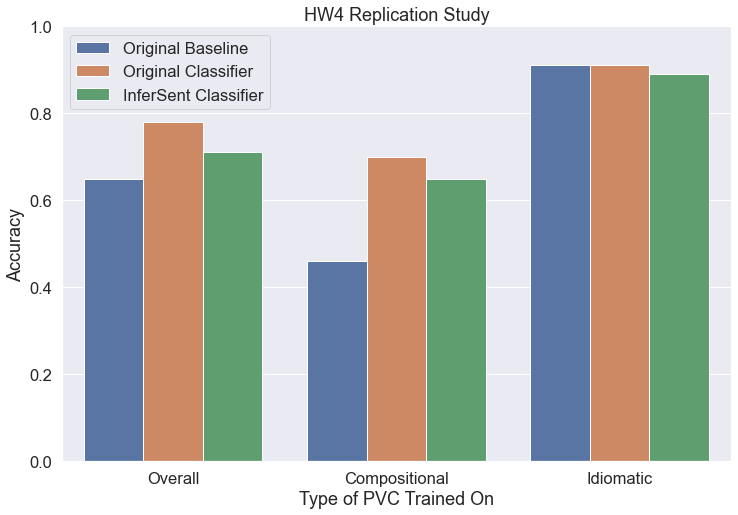

In [49]:
barplot = sns.barplot(data=master_df, x="types", y="accuracies", hue=subtypes)
barplot.set(ylim=(0,1))
barplot.set(title='HW4 Replication Study', xlabel='Type of PVC Trained On', ylabel='Accuracy')
barplot.figure.savefig('hw4_replication.png')